# Snorkel Definitions Experiment: GPT Long

In this experiment, I generate two definitions from ChatGPT, run the same experiment as before, and compare the results. The hypothesis is that a better-formed definition will result in higher semantic similarity scores between research article abstracts and it. My previous definition for the last few experiments was largely from Britannica. In this experiment, I give ChatGPT the following prompt:

> *I'd like to label some research articles, classifying whether they belong to the CS field or not. The approach I'm using is semantic similarity, where I use an embeddings model to encode both the abstract and a definition for the field of CS, then compute the cosine similarity. The issue is that I'm getting very low scores for my definition, which implies I need a better definition. My task for you is this: come up with a definition for the field of CS that encompasses the major contemporary research interests of the field, both theoretical and applied, in such a way that it would allow me to classify the documents well.*

The approach I use is to give ChatGPT information about the validation task I am performing, in the hopes that it will inform a better definition. After this, I will usually prompt it to provide an alternative, shorter two-sentence definition, keeping in mind the earlier instructions. The goal is to get both a longer and shorter definition, and see if the length of the definition also impacts the semantic similarity score.

### Compute semantic similarity scores
Based on the results of the previous experiment, we use the best-performing models from that experiment. we begin the experiment with the **long** GPT definition.

In [1]:
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
import pandas as pd
from sentence_transformers import SentenceTransformer, util

C:\Users\aharve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [7]:
df_defi_short = pd.read_excel("data/research_defs_GPTLong.xlsx")
df = pd.read_csv("data/text-classification-train.csv")
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [8]:
df_scores = pd.DataFrame()
df_scores['abstract'] = df['ABSTRACT'][:200] # Make the labeled only the first 200

computer_science = 1 # Identified as a CS research article
ABSTAIN = 0 # Not identified as a CS research article

i=0

In [10]:
list_key = df_defi_short['Definition'].iloc[i]
list_key

'Computer Science is a multifaceted discipline that investigates the design, analysis, and application of algorithms and computational systems to process and manage information efficiently. It encompasses core theoretical areas such as algorithm design, computational complexity, and cryptography, alongside applied domains like artificial intelligence, machine learning, software engineering, and cybersecurity. Research in computer science also extends to data science, human-computer interaction, and the development of innovative technologies for networks, databases, and embedded systems. This field is fundamental to advancing technology and solving complex problems across various sectors, from healthcare and finance to robotics and social media.'

**Generate embedding for this definition with each model:**

In [11]:
# mixedbread-ai/mxbai-embed-large-v1
embedder1 = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=512)
def_embedding1 = embedder1.encode(list_key, convert_to_tensor=True)

C:\Users\aharve\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# WhereIsAI/UAE-Large-V1
embedder2 = SentenceTransformer("WhereIsAI/UAE-Large-V1")
def_embedding2 = embedder2.encode(list_key, convert_to_tensor=True)

In [21]:
# avsolatorio/GIST-large-Embedding-v0
embedder3 = SentenceTransformer("avsolatorio/GIST-large-Embedding-v0", revision=None)
def_embedding3 = embedder3.encode(list_key, convert_to_tensor=True)

In [26]:
# BAAI/bge-large-zh-v1.5
embedder4 = SentenceTransformer("BAAI/bge-large-zh-v1.5")
def_embedding4 = embedder4.encode(list_key, convert_to_tensor=True)

**Semantic similarity score functions:**

In [14]:
def lf_def_1_score(x):
  dimensions = 512 
  embedder = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=dimensions)
  corpus_embeddings = embedder.encode(x, convert_to_tensor=True)  
  score = util.pytorch_cos_sim(def_embedding1, corpus_embeddings)[0]
  return score

def lf_def_2_score(x):
  embedder = SentenceTransformer("WhereIsAI/UAE-Large-V1")
  corpus_embeddings = embedder.encode(x, convert_to_tensor=True)  
  score = util.pytorch_cos_sim(def_embedding2, corpus_embeddings)[0]
  return score

def lf_def_3_score(x):
  embedder = SentenceTransformer("avsolatorio/GIST-large-Embedding-v0")
  corpus_embeddings = embedder.encode(x, convert_to_tensor=True)  
  score = util.pytorch_cos_sim(def_embedding3, corpus_embeddings)[0]
  return score

def lf_def_4_score(x):
  embedder = SentenceTransformer("BAAI/bge-large-zh-v1.5")
  corpus_embeddings = embedder.encode(x, convert_to_tensor=True)  
  score = util.pytorch_cos_sim(def_embedding4, corpus_embeddings)[0]
  return score

**Generate scores:**

In [15]:
df_scores['LF_1_CS'] = df_scores['abstract'].apply(lf_def_1_score)

In [17]:
df_scores['LF_2_CS'] = df_scores['abstract'].apply(lf_def_2_score)

C:\Users\aharve\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
df_scores['LF_3_CS'] = df_scores['abstract'].apply(lf_def_3_score)

In [27]:
df_scores['LF_4_CS'] = df_scores['abstract'].apply(lf_def_4_score)

In [41]:
# Make into CSV
df_scores.to_csv("data/scores_GPTLong.csv")

### Compute Snorkel labels

In [47]:
df_scores = pd.read_csv("data/scores_GPTLong.csv")
df_scores.head()

,abstract,LF_1_CS,LF_2_CS,LF_3_CS,LF_4_CS
0,Predictive models allow subject-specific inf...,0.5030,0.5061,0.3834,0.4989
1,Rotation invariance and translation invarian...,0.5351,0.5222,0.4093,0.4409
2,We introduce and develop the notion of spher...,0.4327,0.4403,0.2669,0.4600
3,The stochastic Landau--Lifshitz--Gilbert (LL...,0.4228,0.4441,0.3145,0.4699
4,Fourier-transform infra-red (FTIR) spectra o...,0.4831,0.5040,0.3687,0.4914


In [48]:
df_labeled = pd.DataFrame()
df_labeled['abstract'] = df_scores['abstract']

In [49]:
@labeling_function()
def lf_def_1(x):
  score = df_scores[df_scores['abstract'] == x['abstract']]['LF_1_CS'].values[0]
  if score > 0.5:
   return computer_science  
  return ABSTAIN

@labeling_function()
def lf_def_2(x):
  score = df_scores[df_scores['abstract'] == x['abstract']]['LF_2_CS'].values[0]
  if score > 0.5:
   return computer_science  
  return ABSTAIN

@labeling_function()
def lf_def_3(x):
  score = df_scores[df_scores['abstract'] == x['abstract']]['LF_3_CS'].values[0]
  if score > 0.5:
   return computer_science  
  return ABSTAIN

@labeling_function()
def lf_def_4(x):
  score = df_scores[df_scores['abstract'] == x['abstract']]['LF_4_CS'].values[0]
  if score > 0.5:
   return computer_science  
  return ABSTAIN

In [50]:
lfs = [lf_def_1, lf_def_2, lf_def_3, lf_def_4 ]

In [51]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)
L_train = applier.apply(df_labeled)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1486.49it/s]


In [52]:
# Initialize the LabelModel
label_model = LabelModel(cardinality=2, verbose=True)

# Train the LabelModel
label_model.fit(L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
 36%|███████████████████████████                                                | 180/500 [00:00<00:00, 1010.56epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1296.20epoch/s]
INFO:root:Finished Training


In [53]:
# Get the predicted labels (y_train) for the data points
y_train = label_model.predict(L=L_train)
y_train

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0])

In [54]:
df_scores['Snorkel_pred1'] = y_train

### Validating Snorkel

In [55]:
df = pd.read_csv("data/text-classification-train.csv")

In [56]:
df_scores['CS_actual'] = df['Computer Science'][:200]
df = df_scores

**Checking common model metrics:**

INFO:matplotlib.font_manager:generated new fontManager


<Axes: >

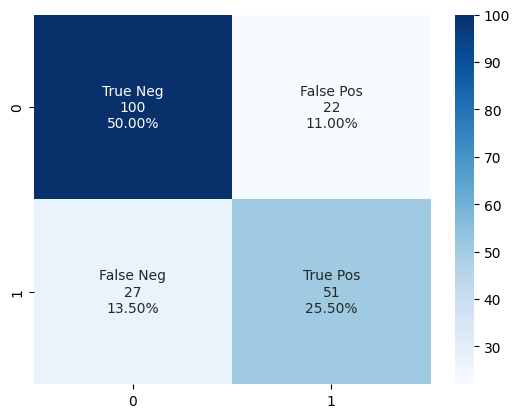

In [58]:
# Source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(df['CS_actual'], df['Snorkel_pred1'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

This is definitely the best semantic similarity model we've gotten so far. Compared to the human-written definition (second-best performing model), we see a slight decrease in true negatives, a doubling in true positives, a large decrease in false negatives, and a slight increase in false positives. It definitely rivals the LLM model too; while it has a quite lower recall, it makes up for it with better precision. The result is a model that is balanced in its capabilities, although still with a while to go.

In [59]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

# Accuracy: the percent of correctly classified data
accuracy = (tn+tp)/(tn+fp+fn+tp)
accuracy

0.755

In [60]:
# Precision: positive predictive value; of those predicted as CS documents, how many were actually CS documents?
precision = (tp)/(tp+fp)
precision

0.6986301369863014

In [61]:
# Recall: of those that were actually CS documents, how many were predicted as CS documents?
recall = (tp)/(tp+fn)
recall

0.6538461538461539

In [62]:
# F1 score: tries to balance precision and recall, with uneven class distribution (large number of actual negs)
f1 = 2*((precision*recall)/(precision+recall))
f1

0.6754966887417219

Compared to the "new embeddings" model: 6 points higher in accuracy, 8 points lower in precision, almost 40 points higher in recall, and a 0.3 difference in f1-score. This score is only 0.03 lower than that of the vanilla LLM. From this analysis, a couple of key results/next steps emerge:

1. Definitions make a difference. Longer definitions might be better, although that is not clear. Both shorter definitions had very similar metrics across the board. Presumably, a better definition would score higher.
2. A fine-tuned LLM might be able to accomplish the same thing as the semantic similarity model without having to deal with the issue of finding the best definition. If this is the case, then an LLM is clearly better.

In [63]:
df.to_csv("data/snorkel_GPTLong_experiment.csv")

### Evaluating semantic similarity scores 

**Distribution of scores:**

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
df_scores = pd.DataFrame()
df_scores = df[['LF_1_CS', 'LF_2_CS', 'LF_3_CS', 'LF_4_CS']]
df_melted = df_scores.melt(var_name='Column', value_name='Value')

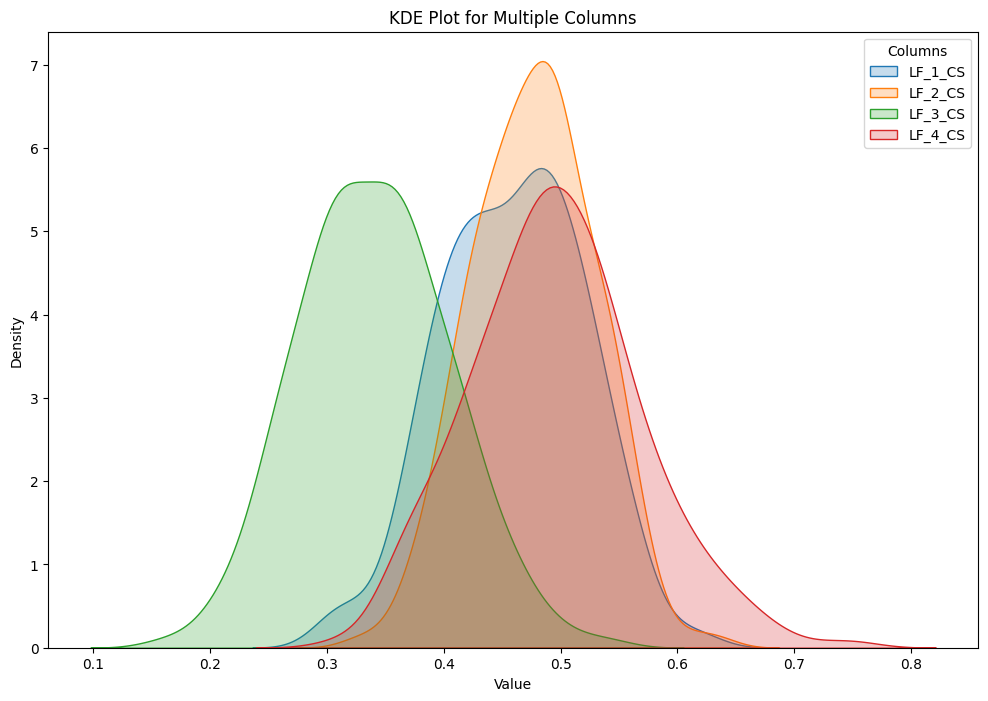

In [69]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot KDE for each column
for column in df_scores.columns:
    sns.kdeplot(df_scores[column], label=column, fill=True)

# Add titles and labels
plt.title('KDE Plot for Multiple Columns')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Columns')
plt.show()

`LF_3_CS` seems like it performs worse than the others, but since it is "outvoted" by the other three better models, the overall Snorkel model is able to retain its accuracy.

**How good are the individual embedding models?**

Model: `mixedbread-ai/mxbai-embed-large-v1`, rank: 18

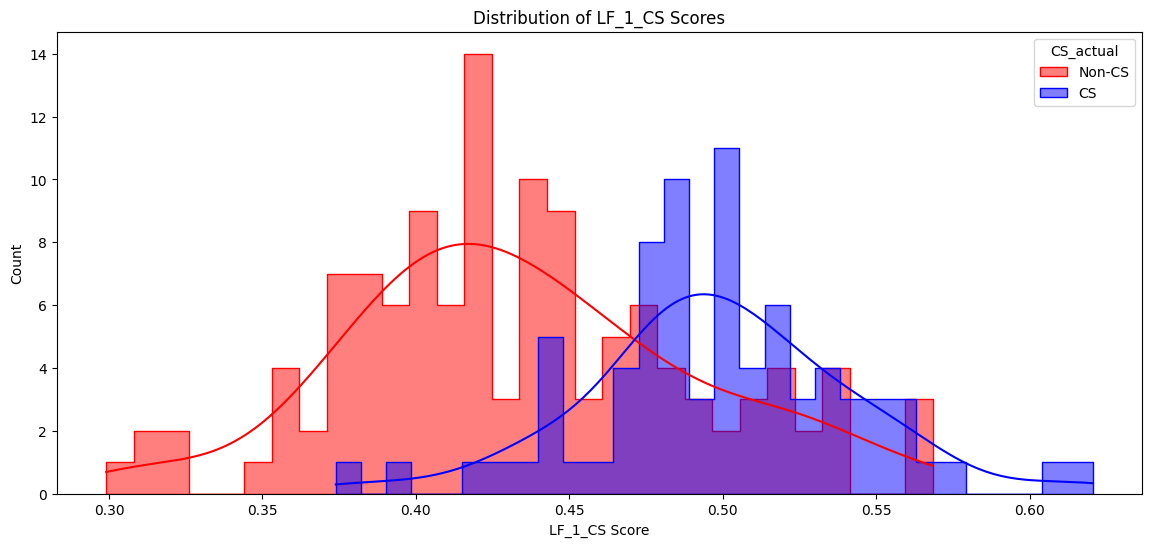

In [71]:
plt.figure(figsize=(14, 6))

# Histogram for Non-CS (CS_actual = 0)
sns.histplot(df[df['CS_actual'] == 0], x='LF_1_CS', color='red', 
             kde=True, bins=30, label='Non-CS', element='step', alpha=0.5)
# Histogram for CS (CS_actual = 1)
sns.histplot(df[df['CS_actual'] == 1], x='LF_1_CS', color='blue', 
             kde=True, bins=30, label='CS', element='step', alpha=0.5)
plt.title('Distribution of LF_1_CS Scores')
plt.xlabel('LF_1_CS Score')
plt.ylabel('Count')
plt.legend(title='CS_actual', loc='upper right')
plt.show()

Model: `WhereIsAI/UAE-Large-V1`, rank: 19

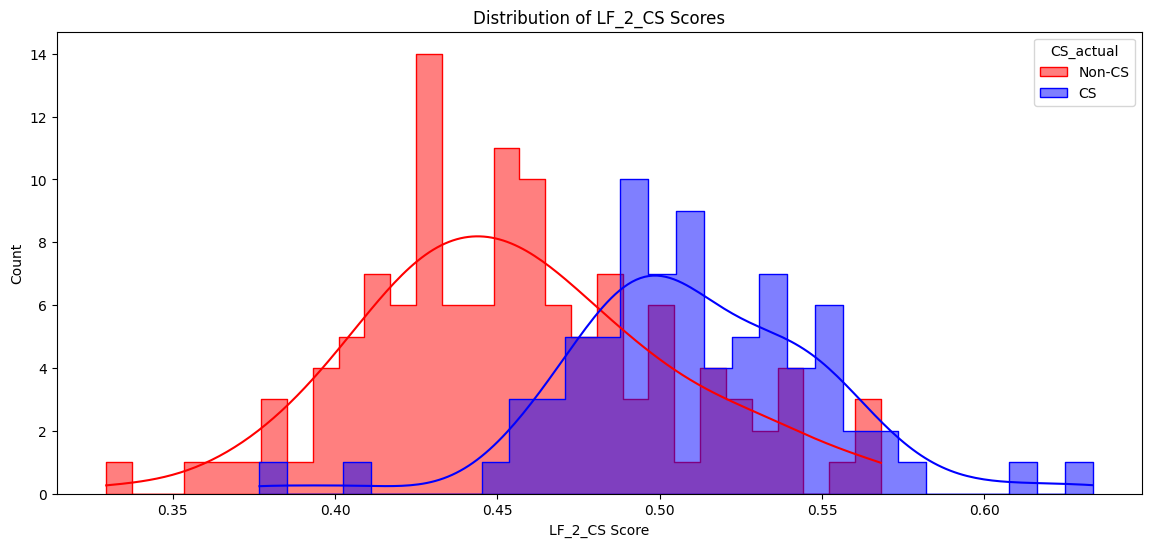

In [72]:
plt.figure(figsize=(14, 6))

# Histogram for Non-CS (CS_actual = 0)
sns.histplot(df[df['CS_actual'] == 0], x='LF_2_CS', color='red', 
             kde=True, bins=30, label='Non-CS', element='step', alpha=0.5)
# Histogram for CS (CS_actual = 1)
sns.histplot(df[df['CS_actual'] == 1], x='LF_2_CS', color='blue', 
             kde=True, bins=30, label='CS', element='step', alpha=0.5)
plt.title('Distribution of LF_2_CS Scores')
plt.xlabel('LF_2_CS Score')
plt.ylabel('Count')
plt.legend(title='CS_actual', loc='upper right')
plt.show()

Model: `avsolatorio/GIST-large-Embedding-v0`, rank: 25

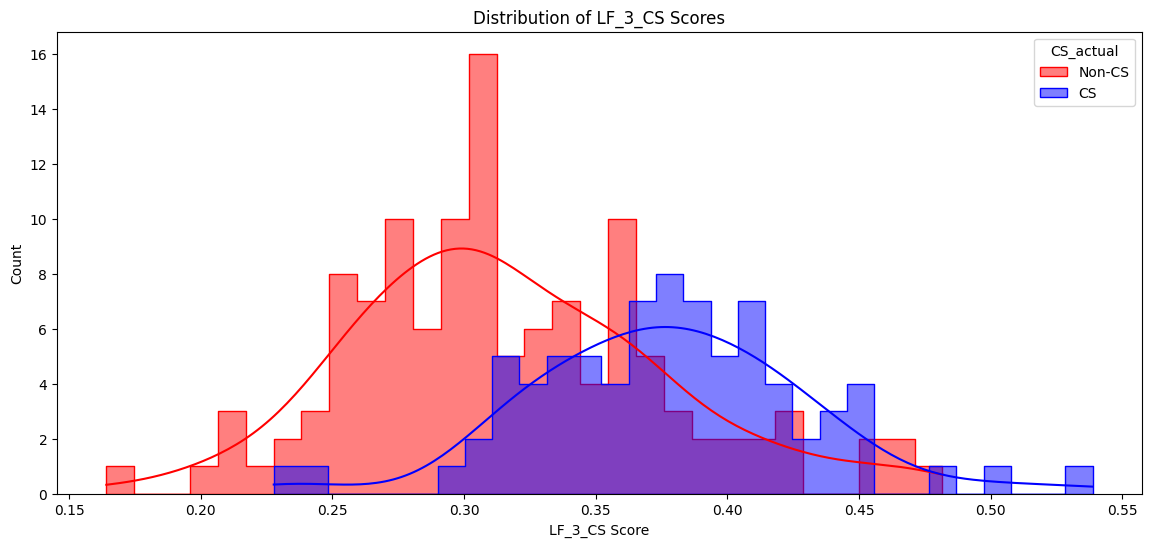

In [73]:
plt.figure(figsize=(14, 6))

# Histogram for Non-CS (CS_actual = 0)
sns.histplot(df[df['CS_actual'] == 0], x='LF_3_CS', color='red', 
             kde=True, bins=30, label='Non-CS', element='step', alpha=0.5)
# Histogram for CS (CS_actual = 1)
sns.histplot(df[df['CS_actual'] == 1], x='LF_3_CS', color='blue', 
             kde=True, bins=30, label='CS', element='step', alpha=0.5)
plt.title('Distribution of LF_3_CS Scores')
plt.xlabel('LF_3_CS Score')
plt.ylabel('Count')
plt.legend(title='CS_actual', loc='upper right')
plt.show()

Model: `BAAI/bge-large-zh-v1.5`, rank: 26

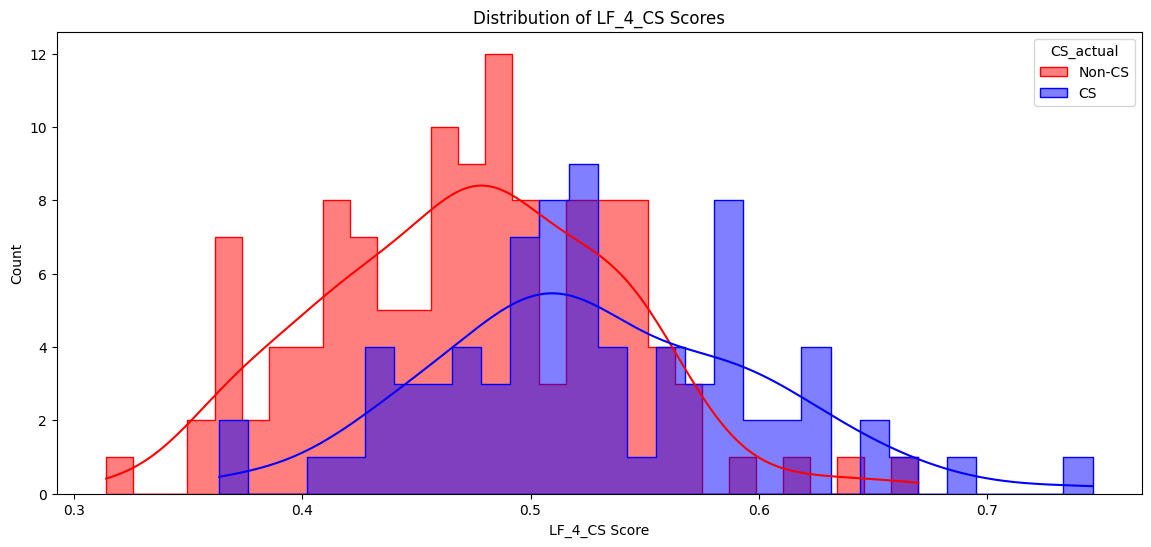

In [74]:
plt.figure(figsize=(14, 6))

# Histogram for Non-CS (CS_actual = 0)
sns.histplot(df[df['CS_actual'] == 0], x='LF_4_CS', color='red', 
             kde=True, bins=30, label='Non-CS', element='step', alpha=0.5)
# Histogram for CS (CS_actual = 1)
sns.histplot(df[df['CS_actual'] == 1], x='LF_4_CS', color='blue', 
             kde=True, bins=30, label='CS', element='step', alpha=0.5)
plt.title('Distribution of LF_4_CS Scores')
plt.xlabel('LF_4_CS Score')
plt.ylabel('Count')
plt.legend(title='CS_actual', loc='upper right')
plt.show()